In [1]:
# Compositional Tree‑LSTM Playground
# Enter a sentence, watch a constituency tree grow and see a vector
# (hidden state) at every node. This is a clean, minimal pipeline.

In [22]:
# *Python ≥ 3.9 recommended; GPU optional.*
!pip install -q spacy benepar transformers torch rich
!python -m spacy download en_core_web_sm
!python -m benepar.download 'benepar_en3'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
/usr/bin/python3: No module named benepar.download


In [23]:
import torch, torch.nn as nn
import spacy, benepar
from transformers import AutoModel, AutoTokenizer
from rich import print  # nicer tree printing

In [24]:
# NLP models

# Download the parser model
benepar.download('benepar_en3')

# Load spaCy and add Benepar
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("benepar", config={"model": "benepar_en3"})

# Load tokenizer
tok_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tok_name)

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert      = AutoModel.from_pretrained('bert-base-uncased').to(DEVICE)

[nltk_data] Downloading package benepar_en3 to /root/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!


In [25]:
# Sentence input
SENTENCE = "Julia kindly gave milk to a very friendly new neighbor after going to the river bank"
doc = nlp(SENTENCE)

sent = list(doc.sents)[0]
tree_str = sent._.parse_string
print(tree_str)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(S (NP (NNP Julia)) (ADVP (RB kindly)) (VP (VBD gave) (NP (NN milk)) (PP (IN to) (NP (DT a) (ADJP (RB very) (JJ 
friendly)) (JJ new) (NN neighbor))) (PP (IN after) (S (VP (VBG going) (PP (IN to) (NP (DT the) (NN river) (NN 
bank))))))))

In [26]:
print(sent._.labels)
print(list(sent._.children))

('S',)

[Julia, kindly, gave milk to a very friendly new neighbor after going to the river bank]

In [27]:
from typing import List

class Node:
    def __init__(self, label:str, span:tuple, children:List['Node']=None):
        self.label    = label
        self.span     = span       # (start_idx, end_idx) in spaCy tokens
        self.children = children or []
        self.h = self.c = None

    def is_leaf(self):
        return not self.children

    def __repr__(self):
        return f"{self.label} {self.span}"

def build_tree(span):
    """
    Recursively build our Node tree from a benepar-annotated spaCy Span.
    `span` (e.g. a sentence Span) should have the benepar’s extensions:
      span._.labels, span._.children, span.start, span.end
    """
    # If no sub-constituents, it’s a leaf token
    children_spans = list(span._.children)
    if not children_spans:
        return Node("TOKEN", (span.start, span.end))

    # Otherwise, build child Nodes
    children = [build_tree(child) for child in children_spans]
    # Use the first label on this span (most trees have exactly one)
    label = span._.labels[0] if span._.labels else "UNKNOWN"
    return Node(label, (span.start, span.end), children)

In [28]:
def print_node_tree(node, tokens, indent=0):
    if node.is_leaf():
        text = tokens[node.span[0]].text
        print(" " * indent + f"{node.label} {node.span} → '{text}'")
    else:
        print(" " * indent + f"{node.label} {node.span}")
        for child in node.children:
            print_node_tree(child, tokens, indent + 2)

root = build_tree(sent)
tokens = list(sent)
print_node_tree(root, tokens)

S (0, 16)

TOKEN (0, 1) → 'Julia'

TOKEN (1, 2) → 'kindly'

VP (2, 16)

TOKEN (2, 3) → 'gave'

TOKEN (3, 4) → 'milk'

PP (4, 10)

TOKEN (4, 5) → 'to'

NP (5, 10)

TOKEN (5, 6) → 'a'

ADJP (6, 8)

TOKEN (6, 7) → 'very'

TOKEN (7, 8) → 'friendly'

TOKEN (8, 9) → 'new'

TOKEN (9, 10) → 'neighbor'

PP (10, 16)

TOKEN (10, 11) → 'after'

S (11, 16)

TOKEN (11, 12) → 'going'

PP (12, 16)

TOKEN (12, 13) → 'to'

NP (13, 16)

TOKEN (13, 14) → 'the'

TOKEN (14, 15) → 'river'

TOKEN (15, 16) → 'bank'

In [29]:
d_in       = 768
num_tokens = len(list(sent))
vec_lookup = torch.randn(num_tokens, d_in, device=DEVICE)

In [30]:
class ChildSumTreeLSTM(nn.Module):
    """
    Child-Sum Tree-LSTM module.

    This implementation performs a bottom-up composition on a tree structure:
      - Leaf nodes receive a fixed input embedding.
      - Internal nodes aggregate their children's hidden states via LSTM-style gating.

    Attributes:
        W_iou (nn.Linear): projects input vector to 3*d_hidden for input, output, update gates.
        U_iou (nn.Linear): projects sum of child hidden states to 3*d_hidden for gates.
        W_f (nn.Linear): projects input vector to d_hidden for forget gates.
        U_f (nn.Linear): projects each child hidden state to d_hidden for forget gates.
        d_hidden (int): dimensionality of hidden states.
    """

    def __init__(self, d_in=768, d_hidden=768):
        super().__init__()
        self.W_iou = nn.Linear(d_in, 3 * d_hidden)
        self.U_iou = nn.Linear(d_hidden, 3 * d_hidden, bias=False)
        self.W_f   = nn.Linear(d_in, d_hidden)
        self.U_f   = nn.Linear(d_hidden, d_hidden, bias=False)
        self.d_hidden = d_hidden

    def forward(self, node):
        """
        Recursively compute hidden (h) and cell (c) states for each node.

        Args:
            node: a Node object with .span, .children, .h, .c attributes.
        Returns:
            (h, c): tensors of shape (d_hidden,) for this node.
        """
        # Leaf case: inject precomputed embedding and zero cell state
        if node.is_leaf():
            h = vec_lookup[node.span[0]]      # embedding for this token
            c = torch.zeros_like(h)           # zero cell state
            node.h, node.c = h, c
            return h, c

        # Internal node: compose children states
        child_states = [self.forward(ch) for ch in node.children]
        h_sum = torch.stack([h for h, _ in child_states]).sum(dim=0)
        x_j = h_sum / len(child_states)      # average child hidden

        # Compute input, output, update gates
        iou = self.W_iou(x_j) + self.U_iou(h_sum)
        i, o, u = iou.chunk(3, dim=-1)
        i = torch.sigmoid(i)
        o = torch.sigmoid(o)
        u = torch.tanh(u)

        # New cell state starts from input modulation
        c = i * u
        # Add forget-gated child cell contributions
        for h_k, c_k in child_states:
            f_k = torch.sigmoid(self.W_f(x_j) + self.U_f(h_k))
            c = c + f_k * c_k

        # Hidden state: output gate applied to tanh(c)
        h = o * torch.tanh(c)
        node.h, node.c = h, c
        return h, c


class ChildSumTreeLSTMWithGates(ChildSumTreeLSTM):
    """
    Extension that records mean forget-gate values for visualization.

    After computing f_k for each child, stores:
        child.f_gate = mean value of f_k
    """

    def forward(self, node):
        # Leaf case (same as base)
        if node.is_leaf():
            h = vec_lookup[node.span[0]]
            c = torch.zeros(self.d_hidden, device=h.device)
            node.h, node.c = h, c
            return h, c

        # Internal nodes
        child_states = [self.forward(ch) for ch in node.children]
        h_sum = torch.stack([h for h, _ in child_states]).sum(dim=0)
        x_j = h_sum / len(child_states)

        # Gates
        iou = self.W_iou(x_j) + self.U_iou(h_sum)
        i, o, u = iou.chunk(3, dim=-1)
        i = torch.sigmoid(i)
        o = torch.sigmoid(o)
        u = torch.tanh(u)

        # New cell state
        c = i * u
        # Record forget gate per child
        for child, (h_k, c_k) in zip(node.children, child_states):
            f_k = torch.sigmoid(self.W_f(x_j) + self.U_f(h_k))
            c = c + f_k * c_k
            child.f_gate = float(f_k.mean().item())

        # Hidden state
        h = o * torch.tanh(c)
        node.h, node.c = h, c
        return h, c

In [31]:
encoded = tokenizer(
  [tok.text for tok in doc],
  is_split_into_words=True,
  return_tensors="pt",
  padding=True, truncation=True
).to(DEVICE)

In [32]:
with torch.no_grad():
  last_hidden = bert(**encoded).last_hidden_state.squeeze(0)  # (L_subpieces, 768)

In [33]:
from collections import defaultdict
word2vecs = defaultdict(list)
for sub_i, word_i in enumerate(encoded.word_ids()):
    if word_i is not None:
        word2vecs[word_i].append(last_hidden[sub_i])

#vec_lookup[i] is exactly the BERT embedding for token i in your doc. We need to Average into one 768‑vector:

vec_lookup = {}
for word_i, vecs in word2vecs.items():
    stacked = torch.stack(vecs, dim=0)        # (num_subpieces,768)
    vec_lookup[word_i] = stacked.mean(0).to(DEVICE)

In [34]:
treelstm = ChildSumTreeLSTM(d_in=768, d_hidden=768).to(DEVICE)
root_vec, root_c = treelstm(root)

In [35]:
treelstm

ChildSumTreeLSTM(
  (W_iou): Linear(in_features=768, out_features=2304, bias=True)
  (U_iou): Linear(in_features=768, out_features=2304, bias=False)
  (W_f): Linear(in_features=768, out_features=768, bias=True)
  (U_f): Linear(in_features=768, out_features=768, bias=False)
)

In [36]:
treelstmwithgates = ChildSumTreeLSTMWithGates(d_in=768, d_hidden=768).to(DEVICE)
root_vec, _ = treelstmwithgates(root)

In [37]:
treelstmwithgates

ChildSumTreeLSTMWithGates(
  (W_iou): Linear(in_features=768, out_features=2304, bias=True)
  (U_iou): Linear(in_features=768, out_features=2304, bias=False)
  (W_f): Linear(in_features=768, out_features=768, bias=True)
  (U_f): Linear(in_features=768, out_features=768, bias=False)
)

S span=(0, 16)  h[0:4]=[-0.11140449 -0.3236798  -0.0653862  -0.18578115]

TOKEN span=(0, 1)  h[0:4]=[ 0.43557644  0.11574924  0.30480468 -0.04852528]  f_gate=0.50

TOKEN span=(1, 2)  h[0:4]=[-0.01029376  0.08047592  0.18367378  0.17911749]  f_gate=0.50

VP span=(2, 16)  h[0:4]=[-0.04176749 -0.2852199   0.09351549  0.01159996]  f_gate=0.50

TOKEN span=(2, 3)  h[0:4]=[ 0.04198011 -0.6065556   0.31695414  0.3413015 ]  f_gate=0.50

TOKEN span=(3, 4)  h[0:4]=[ 0.79430777  0.09103965  0.03536199 -0.01226468]  f_gate=0.50

PP span=(4, 10)  h[0:4]=[-0.00906544 -0.17719044  0.08635656  0.07369345]  f_gate=0.50

TOKEN span=(4, 5)  h[0:4]=[-0.15560585  0.23470472  0.49581546 -0.09678317]  f_gate=0.50

NP span=(5, 10)  h[0:4]=[-0.3112213  -0.17248756 -0.01153428  0.05135421]  f_gate=0.50

TOKEN span=(5, 6)  h[0:4]=[-0.7993098  -0.16168717  0.28838363  0.26976278]  f_gate=0.50

ADJP span=(6, 8)  h[0:4]=[-0.0994164  -0.20873682 -0.01372665 -0.0391055 ]  f_gate=0.50

TOKEN span=(6, 7)  h[0:4]=[-0.15110084 -0.30198205  0.4607488   0.30006543]  f_gate=0.50

TOKEN span=(7, 8)  h[0:4]=[-0.3020448  -0.08936671  0.8598954   0.04836105]  f_gate=0.50

TOKEN span=(8, 9)  h[0:4]=[-0.09700058 -0.56845045  0.8697816   0.06703834]  f_gate=0.50

TOKEN span=(9, 10)  h[0:4]=[ 0.4236523  -0.3426965   0.3398661   0.41823518]  f_gate=0.50

PP span=(10, 16)  h[0:4]=[-0.06563997 -0.15726143 -0.1388634   0.08341106]  f_gate=0.50

TOKEN span=(10, 11)  h[0:4]=[-0.28316587 -0.5106477   0.8047624   0.59328634]  f_gate=0.50

S span=(11, 16)  h[0:4]=[-0.27847162 -0.11608322 -0.18289268  0.06518108]  f_gate=0.50

TOKEN span=(11, 12)  h[0:4]=[-0.21190013 -0.7596964   0.19129156  0.12393279]  f_gate=0.50

PP span=(12, 16)  h[0:4]=[-0.17809655 -0.18049572 -0.10570572  0.06683951]  f_gate=0.50

TOKEN span=(12, 13)  h[0:4]=[-0.39336985 -0.4479483   0.00229973  0.27679455]  f_gate=0.50

NP span=(13, 16)  h[0:4]=[-0.32783774 -0.24657156 -0.08244148  0.04146996]  f_gate=0.50

TOKEN span=(13, 14)  h[0:4]=[-0.09709338 -0.3430503  -0.09520599  0.6733825 ]  f_gate=0.50

TOKEN span=(14, 15)  h[0:4]=[ 0.38479853  0.32664546 -0.11669878  0.43857792]  f_gate=0.50

TOKEN span=(15, 16)  h[0:4]=[-0.5020384  -0.50083125 -0.44417685 -0.06907469]  f_gate=0.50

Sentence embedding (root h[0:8]):
[
    -0.11140448600053787,
    -0.3236798048019409,
    -0.06538619846105576,
    -0.18578115105628967,
    0.2561306357383728,
    0.09066326171159744,
    0.25311046838760376,
    -0.22635819017887115
]

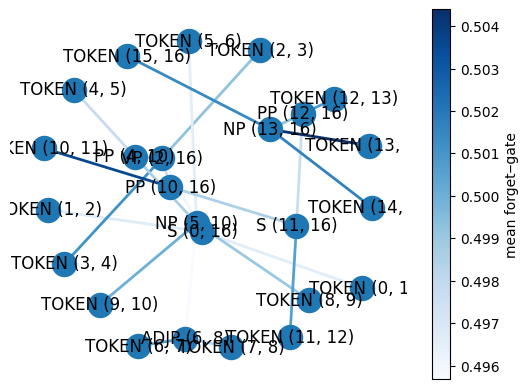

In [38]:
# Child‑Sum Tree‑LSTM implementation and Viz (ugly graph, however I plan on making it pretty, genertive, and 3d.
import networkx as nx
import matplotlib.pyplot as plt

# A) Show function that also prints any f_gate on *children*
def show(node, depth=0):
    pad  = "  " * depth
    gate = f"  f_gate={node.f_gate:.2f}" if hasattr(node, "f_gate") else ""
    # detach before moving to numpy
    h4   = node.h[:4].detach().cpu().numpy()
    print(f"{pad}{node.label} span={node.span}  h[0:4]={h4}{gate}")
    for ch in node.children:
        show(ch, depth+1)

show(root)
print("\nSentence embedding (root h[0:8]):", root.h[:8].detach().tolist())

# B) Build graph and draw with edge colours = forget‐gate
G = nx.DiGraph()
def add_edges(G, node, parent=None):
    if parent is not None:
        G.add_edge(parent, node)
    for ch in node.children:
        add_edges(G, ch, node)

add_edges(G, root)

# extract edge colours (child.f_gate on each edge)
edges      = list(G.edges())
edge_colors = [child.f_gate for _,child in edges]

# Create a figure and an axes explicitly
fig, ax = plt.subplots()

pos = nx.spring_layout(G)   # or graphviz_layout if you have pygraphviz
nx.draw(
    G, pos,
    with_labels=True,
    arrows=False,
    node_size=300,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
    ax=ax # Associate the graph with the axes
)
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                           norm=plt.Normalize(vmin=min(edge_colors),
                                              vmax=max(edge_colors)))
sm.set_array([])

# Now, provide the 'ax' argument to colorbar
plt.colorbar(sm, ax=ax, label="mean forget‒gate")
plt.show()